In [2]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import xarray as xr

import matplotlib.pyplot as plt

from pymc import HalfCauchy, Model, Normal, sample

import warnings
warnings.filterwarnings("ignore")

par_3_to_remove = "The Links at Rolling Meadows Golf Club"

df = pd.read_csv("golf_18birdies_data.csv")
df['strokes'] = df.apply(lambda row: row['strokes'] * 2 if row['is_18_holes'] == 0 else row['strokes'], axis=1)


rows_to_remove = df['name'] == par_3_to_remove
removed_count = rows_to_remove.sum()
df = df[~rows_to_remove]

df= df.reset_index()
df['index'] = df.index
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')



df.head(3)

,index,timestamp,score,strokes,holeStrokes,stats_aces,stats_doubleEagleOrBetter,stats_eagles,stats_birdies,stats_pars,...,hole_10,hole_11,hole_12,hole_13,hole_14,hole_15,hole_16,hole_17,hole_18,date
0,0,2023-09-29 15:28:40.982,7,86,"[6, 6, 5, 4, 5, 4, 5, 4, 4]",0,0,0,0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-09-29
1,1,2023-09-29 20:40:02.616,10,88,"[5, 5, 4, 5, 6, 5, 5, 5, 4]",0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-09-29
2,2,2023-09-30 02:09:34.052,22,93,"[7, 3, 6, 5, 5, 6, 4, 5, 8, 5, 6, 5, 6, 3, 6, ...",0,0,0,0,6,...,5.0,6.0,5.0,6.0,3.0,6.0,4.0,5.0,4.0,2023-09-30


In [ ]:
##Training Model (Fitting Linear Regression Line)

RANDOM_SEED = 1111
np.random.seed(RANDOM_SEED)

data = df[['index', 'strokes']]

x = data['index'].values
y = data['strokes'].values

# Extract the last 4 values for testing
x_test = x[-4:]
y_test = y[-4:]

# Use the rest of the data for training
x_train = x[:-4]
y_train = y[:-4]

with pm.Model() as golf_score_model:
    #data
    time = pm.MutableData("time",x_train)

    #prior
    intercept = pm.Normal("intercept", 0, sigma=20) #y-intercept
    # slope = pm.HalfStudentT("slope", sigma=2, nu=1) ##slope
    slope = pm.Normal("slope", mu=0, sigma=1)
    sigma = pm.HalfNormal("sigma", sigma=11) ##Standard Deviation

    #linear regression line y = mx + b
    mu = (
        intercept + (slope * time)
          )
    
    # Define likelihood
    pm.Normal(
        "GolfScores",
        mu=mu,
        sigma=sigma,
        observed= y_train
        )
    
    ##Sampling
    with golf_score_model:
        idata = pm.sample(draws =500,chains=4,random_seed=RANDOM_SEED)
        idata.extend(pm.sample_prior_predictive(random_seed=RANDOM_SEED))
        idata.extend(pm.sample_posterior_predictive(idata, random_seed=RANDOM_SEED))
   



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.


In [30]:
idata.posterior

<xarray.Dataset>
Dimensions:    (chain: 4, draw: 1000)
Coordinates:
  * chain      (chain) int32 0 1 2 3
  * draw       (draw) int32 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
Data variables:
    intercept  (chain, draw) float64 94.87 92.59 96.71 ... 96.62 97.65 95.32
    slope      (chain, draw) float64 0.1981 0.3173 0.02918 ... 0.1045 0.1639
    sigma      (chain, draw) float64 8.628 7.209 7.737 ... 8.467 8.916 8.283
Attributes:
    created_at:                 2025-02-01T02:06:39.341878
    arviz_version:              0.12.1
    inference_library:          pymc
    inference_library_version:  4.1.4
    sampling_time:              55.894229888916016
    tuning_steps:               1000

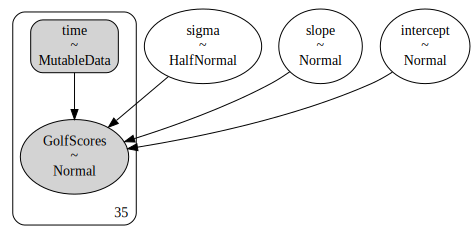

In [31]:
pm.model_to_graphviz(golf_score_model) 

In [32]:
az.summary(idata,round_to=1,var_names=["intercept", "slope"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,96.3,2.6,91.8,101.5,0.1,0.0,1679.5,1805.9,1.0
slope,0.1,0.1,-0.1,0.4,0.0,0.0,1723.7,1778.4,1.0


array([<AxesSubplot:title={'center':'intercept'}>,
       <AxesSubplot:title={'center':'slope'}>], dtype=object)

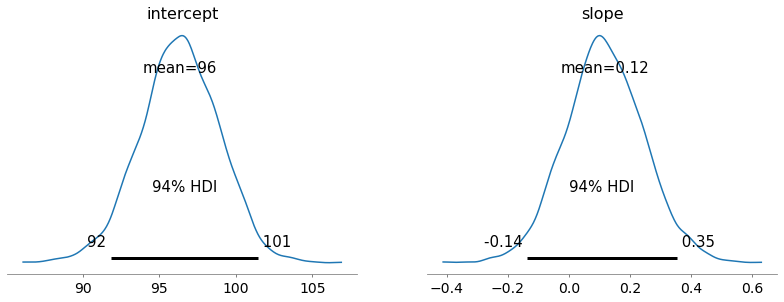

In [33]:
az.plot_posterior(idata, var_names=["intercept", "slope"])

array([[<AxesSubplot:title={'center':'intercept'}>,
        <AxesSubplot:title={'center':'intercept'}>],
       [<AxesSubplot:title={'center':'slope'}>,
        <AxesSubplot:title={'center':'slope'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

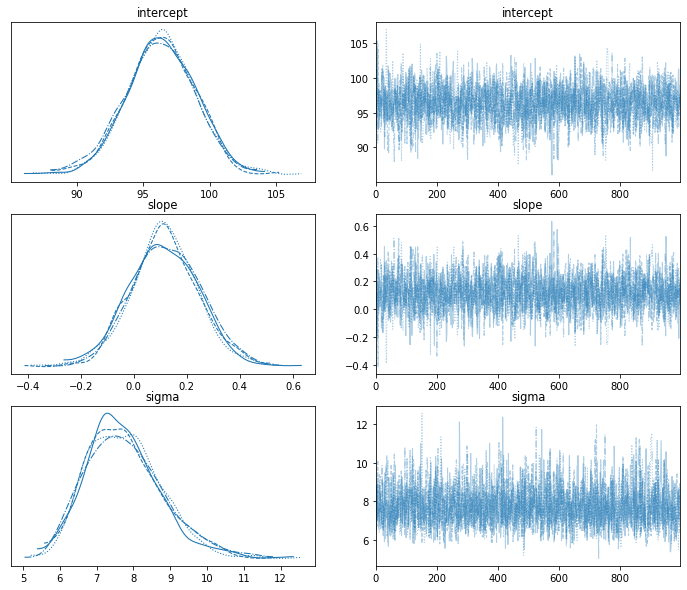

In [34]:
az.plot_trace(idata, figsize=(12, 10))

In [35]:
# Predicting with model
with golf_score_model:
    pm.set_data({"time": x_test})
    predictions = pm.sample_posterior_predictive(idata, random_seed=RANDOM_SEED)

posterior_samples = predictions.posterior_predictive['GolfScores']

In [36]:

# Mean prediction (Expected value)
mean_preds = posterior_samples.mean(dim=("chain", "draw"))
print("Mean Preds: ", np.round(mean_preds.values, 2))  # Round to 2 decimal places

# Median prediction
median_preds = posterior_samples.median(dim=("chain", "draw"))
print("Median Preds: ", np.round(median_preds.values, 2))  # Round to 2 decimal places

Mean Preds:  [100.58 100.38 100.56 100.75]
Median Preds:  [100.7  100.32 100.54 100.77]


95% Credible Interval: <xarray.DataArray 'GolfScores' (GolfScores_dim_0: 4, hdi: 2)>
array([[ 83.61920552, 117.04153276],
       [ 83.82514319, 116.89659604],
       [ 83.3540384 , 117.10733135],
       [ 84.45879924, 116.86819012]])
Coordinates:
  * GolfScores_dim_0  (GolfScores_dim_0) int32 0 1 2 3
  * hdi               (hdi) <U6 'lower' 'higher'


array([<AxesSubplot:title={'center':'GolfScores\n0'}>,
       <AxesSubplot:title={'center':'GolfScores\n1'}>,
       <AxesSubplot:title={'center':'GolfScores\n2'}>,
       <AxesSubplot:title={'center':'GolfScores\n3'}>], dtype=object)

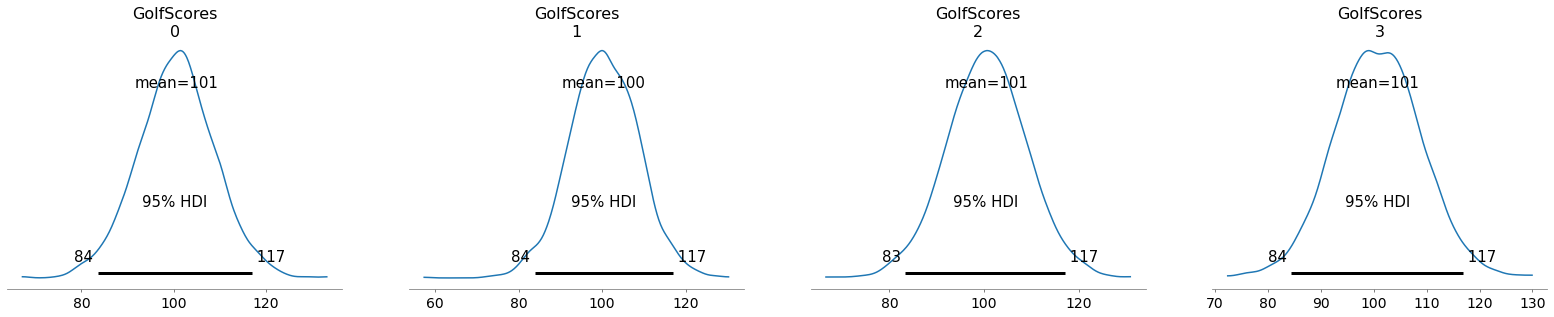

In [37]:
hdi = az.hdi(predictions.posterior_predictive, hdi_prob=0.95)
print("95% Credible Interval:", hdi['GolfScores'])
az.plot_posterior(predictions.posterior_predictive['GolfScores'], hdi_prob=0.95)

50% Credible Interval: <xarray.DataArray 'GolfScores' (GolfScores_dim_0: 4, hdi: 2)>
array([[ 95.78427194, 106.57218089],
       [ 94.10634074, 105.19138887],
       [ 94.40637422, 105.47923411],
       [ 95.0546976 , 105.98564429]])
Coordinates:
  * GolfScores_dim_0  (GolfScores_dim_0) int32 0 1 2 3
  * hdi               (hdi) <U6 'lower' 'higher'


array([<AxesSubplot:title={'center':'GolfScores\n0'}>,
       <AxesSubplot:title={'center':'GolfScores\n1'}>,
       <AxesSubplot:title={'center':'GolfScores\n2'}>,
       <AxesSubplot:title={'center':'GolfScores\n3'}>], dtype=object)

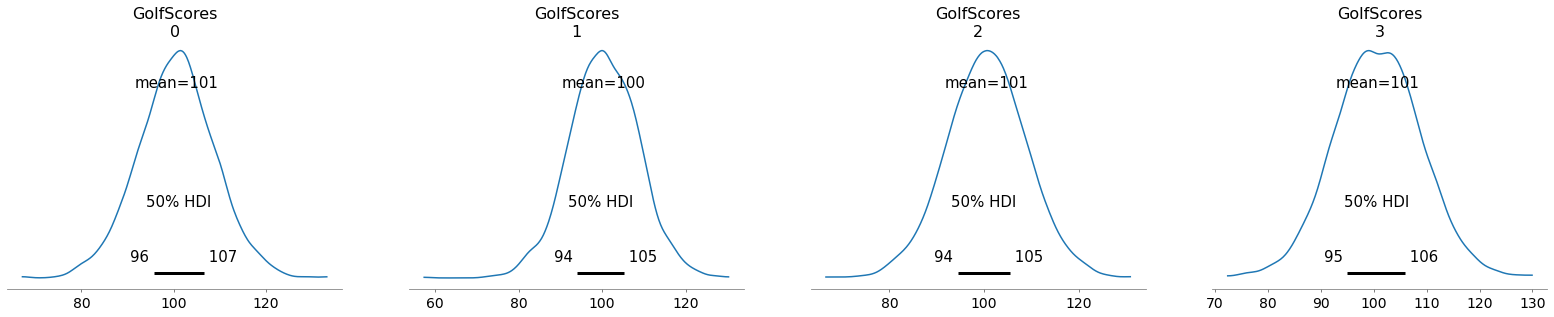

In [38]:
hdi = az.hdi(predictions.posterior_predictive, hdi_prob=0.5)
print("50% Credible Interval:", hdi['GolfScores'])
az.plot_posterior(predictions.posterior_predictive['GolfScores'], hdi_prob=0.5)

In [39]:
future_times = np.array([max(x_test) + 1, max(x_test) + 2, max(x_test) + 3])  # Example future indices
with golf_score_model:
    pm.set_data({"time": future_times})
    future_predictions = pm.sample_posterior_predictive(idata, random_seed=RANDOM_SEED)
print(future_predictions.posterior_predictive['GolfScores'])

<xarray.DataArray 'GolfScores' (chain: 4, draw: 1000, GolfScores_dim_0: 3)>
array([[[ 89.94445761,  90.2952054 , 108.83535875],
        [105.65746996, 118.62785628, 108.19221702],
        [ 96.9017262 ,  87.32049711,  94.11458258],
        ...,
        [ 98.29118767,  80.65841337, 105.7115464 ],
        [ 92.57940591,  99.54787522,  98.83286794],
        [ 92.99526311,  90.36123421,  95.10824461]],

       [[ 91.02634038, 103.29387594, 102.28918841],
        [110.74242681, 102.30106233, 100.97270307],
        [107.72659018,  98.40091953,  98.57326412],
        ...,
        [ 93.13807316, 102.07986119, 101.4810378 ],
        [ 95.02668025, 117.00463088, 106.26796619],
        [ 92.99338121,  88.59123583,  90.84333183]],

       [[ 93.30943326, 102.02046942, 108.13300309],
        [106.1521942 , 101.22646072, 104.45452419],
        [118.74658198, 110.91769193, 111.65143633],
        ...,
        [ 96.74388524,  96.10755863, 105.67738036],
        [102.71242192,  94.22376831, 101.09027381